In [1]:
from nerfstudio.pipelines.diffusion_nerf_pipeline import DiffusionNerfPipeline
from nerfstudio.data.datamanagers.ad_datamanager import ADDataManagerConfig, ADDataManager
from nerfstudio.data.dataparsers.pandaset_dataparser import PandaSetDataParserConfig

from nerfstudio.cameras.camera_optimizers import CameraOptimizerConfig
from nerfstudio.models.neurad import NeuRADModelConfig

In [2]:
%load_ext autoreload
%autoreload 2
%cd ~/dev/neurad-studio

/home/gasparyanartur/dev/neurad-studio


In [3]:
!ls models/diffusionnerf/base-neurad/001/

config.yml  dataparser_transforms.json	nerfstudio_models  wandb


In [7]:

from nerfstudio.generative.diffusion_model import DiffusionModelConfig, DiffusionModelId, DiffusionModelType
from nerfstudio.pipelines.diffusion_nerf_pipeline import DiffusionNerfConfig

config=DiffusionNerfConfig(
    max_steps=20001,
    calc_fid_steps=tuple(range(0, 20001, 5000)),
    ray_patch_size=(128, 128),
    datamanager=ADDataManagerConfig(
        train_num_lidar_rays_per_batch=16384,
        eval_num_lidar_rays_per_batch=16384,
        dataparser=PandaSetDataParserConfig(add_missing_points=True, cameras=("front",)),
        num_processes=0
    ),
    model=NeuRADModelConfig(
        eval_num_rays_per_chunk=1 << 15,
        camera_optimizer=CameraOptimizerConfig(mode="off"),  # SO3xR3
        rgb_upsample_factor=4,
    ),
    diffusion_model=DiffusionModelConfig(
        dtype="fp16",
    ),
    augment_phase_step=0,
    augment_strategy="none",
    nerf_checkpoint="models/diffusionnerf/base-neurad/001/nerfstudio_models/step-000020000.ckpt"
)


In [8]:
import torch


device = torch.device("cuda")
pipe = DiffusionNerfPipeline(config, device=device)

Output()

Output()

Setting up evaluation dataset...

Caching all 40 images.

Output()

Caching all 40 images.

Output()

/home/gasparyanartur/dev/neurad-studio/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gasparyanartur/dev/neurad-studio/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/gasparyanartur/dev/neurad-studio/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [9]:
import matplotlib.pyplot as plt
from copy import deepcopy

import torch
import torchvision.transforms as tvtf

from nerfstudio.cameras.cameras import Cameras

In [10]:
pipe.eval()

camera, batch = pipe.datamanager.next_eval_image(0)
outputs = pipe.model.get_outputs_for_camera(camera)
metrics_dict, images_dict = pipe.model.get_image_metrics_and_images(
    outputs, batch
)

print("datamanager outputs -", ", ".join(batch.keys()))
print("nerf outputs -", ", ".join(outputs.keys()))

datamanager outputs - image_idx, image
nerf outputs - features, depth, accumulation, prop_depth_0, prop_depth_1, rgb, intensity, ray_drop_logits, ray_drop_prob


/home/gasparyanartur/dev/neurad-studio/venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(


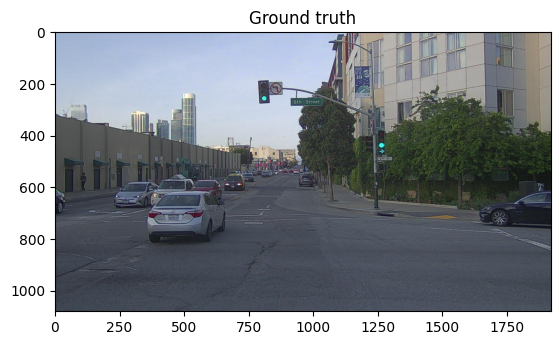

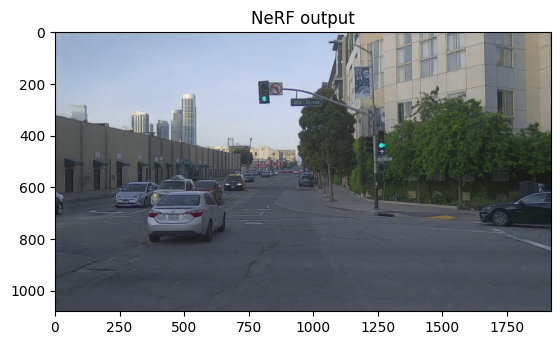

GT - max: 1.000, min: 0.000, shape: torch.Size([1080, 1920, 3])
NeRF - max: 0.977, min: 0.038, shape: torch.Size([1080, 1920, 3])


In [11]:
import matplotlib.pyplot as plt

gt = batch["image"]
nerf_out = outputs["rgb"]

plt.imshow(gt.cpu().numpy())
plt.title("Ground truth")
plt.show()

plt.imshow(nerf_out.cpu().numpy())
plt.title("NeRF output")
plt.show()

print(f"GT - max: {gt.max():.3f}, min: {gt.min():.3f}, shape: {gt.shape}")
print(f"NeRF - max: {nerf_out.max():.3f}, min: {nerf_out.min():.3f}, shape: {nerf_out.shape}")


In [36]:
pipe.train()

ray_bundle, batch = pipe.datamanager.next_train(0)
cameras = pipe.datamanager.train_dataset.cameras

model_outputs = pipe.model(
    deepcopy(ray_bundle), patch_size=pipe.config.ray_patch_size
)
metrics_dict = pipe.model.get_metrics_dict(model_outputs, batch)
loss_dict = pipe.model.get_loss_dict(model_outputs, batch, metrics_dict)

print("ray bundle -", ", ".join(vars(ray_bundle).keys()))
print("datamanager outputs -", ", ".join(batch.keys()))
print("nerf outputs -", ", ".join(model_outputs.keys()))
print("loss outputs -", ", ".join(loss_dict.keys()))


ray bundle - origins, directions, pixel_area, camera_indices, nears, fars, metadata, times, termination_distances, _shape
datamanager outputs - image, is_lidar, did_return, img_indices, lidar, distance
nerf outputs - depth, accumulation, prop_depth_0, prop_weights_loss_0, prop_depth_1, prop_weights_loss_1, weights_list, ray_samples_list, non_nearby_weights, non_nearby_lidar_ray_indices, rgb, intensity, ray_drop_logits
loss outputs - rgb_loss, vgg_loss, interlevel_loss, distortion_loss, depth_loss_0, carving_loss_0, depth_loss_1, carving_loss_1, depth_loss, intensity_loss, carving_loss, ray_drop_loss


RGB - max: 1.000, min: 0.000, shape: torch.Size([512, 512, 3])


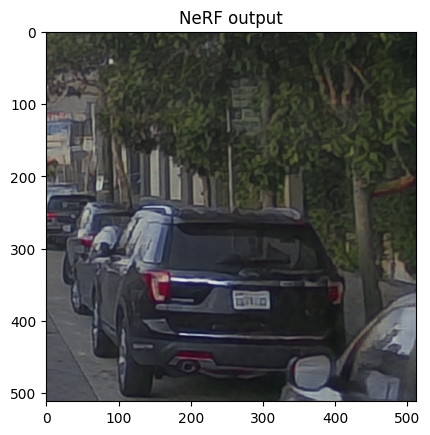

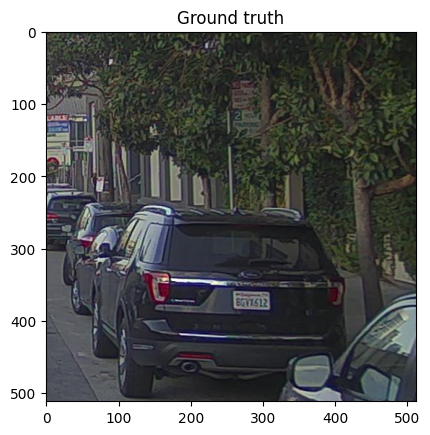

In [47]:
gt = batch["image"][0]
print(f"RGB - max: {gt.max():.3f}, min: {gt.min():.3f}, shape: {gt.shape}")

rgb = model_outputs["rgb"][0]
plt.imshow(rgb.detach().cpu().numpy())
plt.title("NeRF output")
plt.show()

plt.imshow(gt.cpu().numpy())
plt.title("Ground truth")
plt.show()

In [74]:
from typing import Tuple
from torch import Tensor

from nerfstudio.pipelines.diffusion_nerf_pipeline import is_cam_ray


torch.Size([49152, 1])


torch.Size([2, 3, 128, 128])

In [88]:
from nerfstudio.pipelines.diffusion_nerf_pipeline import get_cam_rays_from_bundle, transform_ray_bundle

patch_size = pipe.config.ray_patch_size
print("ray bundle shape: ", ray_bundle.origins[~ray_bundle.metadata["is_lidar"].flatten()].shape, ray_bundle.directions.shape)
print("patch size: ", patch_size, "->")
print(patch_size[0] * patch_size[1] * 3)
origins, directions = get_cam_rays_from_bundle(ray_bundle, patch_size)



#pose_aug = pipe._get_pose_augmentation(0)
pose_aug = torch.Tensor([-1, 0, 0, 0, 0, -30]).to(device)

aug_ray_bundle = transform_ray_bundle(ray_bundle, pose_aug, cameras)
aug_outputs = pipe.model(aug_ray_bundle, patch_size=patch_size)

print("ray bundle -", ", ".join(vars(aug_ray_bundle).keys()))


print("Original ray bundle: ", ray_bundle.origins, ray_bundle.directions)

ray bundle shape:  torch.Size([32768, 3]) torch.Size([49152, 3])
patch size:  (128, 128) ->
49152
ray bundle - origins, directions, pixel_area, camera_indices, nears, fars, metadata, times, termination_distances, _shape
Original ray bundle:  tensor([[-0.3164, 33.7933, -0.0552],
        [-0.3164, 33.7933, -0.0552],
        [-0.3164, 33.7933, -0.0552],
        ...,
        [ 0.3338, -1.2500, -0.1194],
        [ 0.3378, -0.9914, -0.1232],
        [ 0.3398, -0.8608, -0.1251]], device='cuda:0') tensor([[ 0.0864,  0.9917,  0.0955],
        [ 0.0884,  0.9915,  0.0954],
        [ 0.0904,  0.9913,  0.0953],
        ...,
        [-0.8063,  0.5885, -0.0593],
        [ 0.5979,  0.8005, -0.0415],
        [ 0.9847,  0.1255, -0.1209]], device='cuda:0')


In [93]:
ray_bundle.termination_distances

torch.Size([49152, 1])

In [33]:
print(pipe.model.get_submodule("rgb_decoder"))

Sequential(
  (0): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1))
  (1): ReLU(inplace=True)
  (2): BasicBlock(
    (res_branch): Identity()
    (main_branch): Sequential(
      (0): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (final_activation): ReLU(inplace=True)
  )
  (3): BasicBlock(
    (res_branch): Identity()
    (main_branch): Sequential(
      (0): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, a